In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from numpy.random import default_rng
from scipy import optimize
from scipy.integrate import quad 
import time
rng = default_rng()

In [2]:
#Killian Coustoulin
#21304858

# Illustration de la méthode de simulation d’un processus de Poisson homogène ou inhomogène par la méthode de thinning :


Les processus de Poisson sont utilisés pour modéliser l'apparition d'évènements aléatoire au cours du temps. Quelques exemples d'utilisations des processus de Poisson : 

    -Arrivée de clients à un centre-commercial
    -Nombre d'appel reçu à un centre d'appel durant une période donnée
    -Apparition de tremblement de terre dans une région spécifique
    -Désintégration radioactive

La liste n'est évidemment pas exhaustive, on retrouve des processsus de Poisson dans de nombreux autres domaines, comme la télécommunication, la biologie....

Toutes les cellules peuvent être relancés (dans l'ordre bien sûr) et s'exécutent relativement rapidement, sauf les 
trois dernières, qui servent à comparer les performances des divers algorithmes et sont assez lentes.

## Partie 1 : Simulation des processus de poisson homogène et non homogène 
### Processus de Poisson homogène : 


Un processus de Poisson de paramètre (ou intensité) $\lambda > 0$, est un processus de comptage associé à un processus ponctuel $(T_n)_{n \ge 1}$ où les variables aléatoires $T_n$ (appelées instants de sauts) sont définies par
\begin{equation*}
    \forall n \ge 1, \quad T_n - T_{n-1} = S_n, \qquad \text{en posant $T_0 = 0$}
\end{equation*}
avec $(S_n)_{n \ge 1}$ suite _i.i.d._ de loi exponentielle de paramètre $\lambda > 0$.

Pour tout $t \ge 0$, on définit 
\begin{equation*}
    N_t = \sum_{n \ge 0} \mathbf{1}_{T_n \le t},
\end{equation*}



#### Simulation d'un processus homogène par la méthode de la fonction inverse

In [3]:
def One_Poisson_Homogene_Inverse(lambd, T):
    sol = [0]
    compteur = 0 
    while sol[-1]<T:
        u = rng.uniform()
        w = -np.log(u)/lambd
        sol.append(sol[-1]+w)
        compteur+=1
    
    sol[-1]=T
    return np.array(sol)

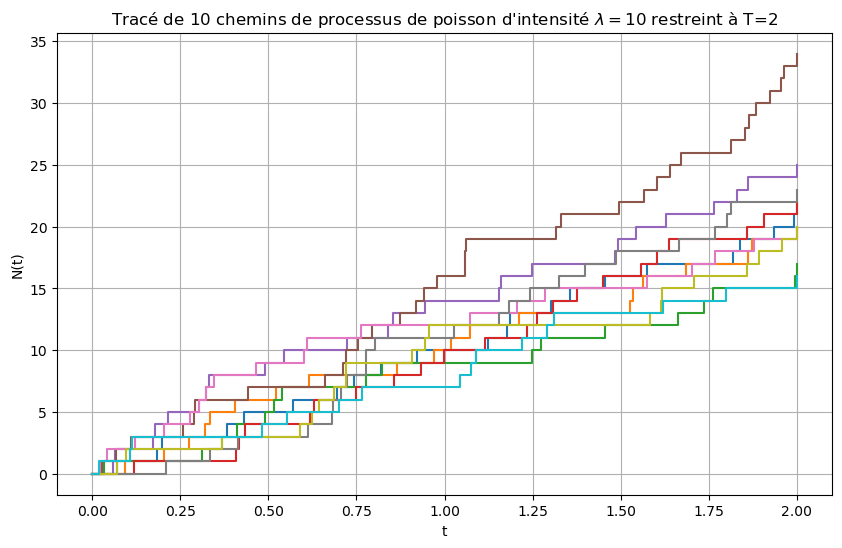

In [4]:
n = 10
lambd = 10
T = 2
sol = [ One_Poisson_Homogene_Inverse(lambd, T) for _ in range(n) ]


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

for j in range(n):
    support = np.arange(len(sol[j]))
    ax.step(sol[j], support, where='post')
    
ax.grid()
ax.set_title(f"Tracé de {n} chemins de processus de poisson d'intensité $\lambda=${lambd} restreint à T={T}")
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()


#### Simulation d'un processus homogène par la méthode d'arrangement

Si $(N_t)_{t \ge 0}$ est un processus de Poisson d'intensité $\lambda > 0$, alors conditionnellement à l'événement $N_T = n$ les instants de sauts $(T_k)_{k=1,\dots,n}$ (tels que $0 < T_1 < \dots < T_n \le T$) ont même loi que le réordonnement croissant d'un vecteur $(U_1, \dots, U_n) \sim \mathcal{U}([0,T]^n)$.

In [5]:
def One_Poisson_Homogene_Sort(lambd, T):
    size = rng.poisson(lam=lambd*T)
    times = np.empty(size+2)
    times[0] = 0
    times[1:-1] = np.sort(rng.uniform(size=size, low=0, high=T))
    times[-1] = T
    return times

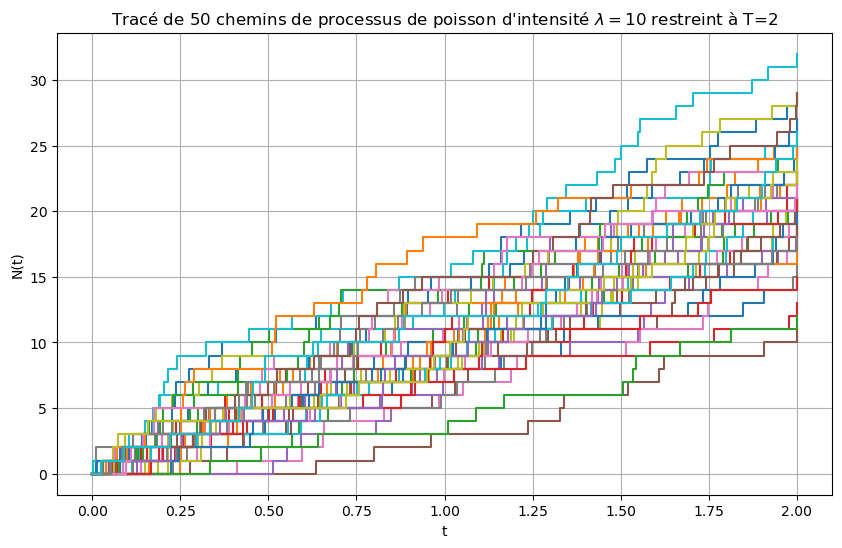

In [6]:
n = 50
lambd = 10
T = 2
sol = [ One_Poisson_Homogene_Sort(lambd, T) for _ in range(n) ]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

for j in range(n):
    support = np.arange(len(sol[j]))
    ax.step(sol[j], support, where='post')
    
ax.grid()
ax.set_title(f"Tracé de {n} chemins de processus de poisson d'intensité $\lambda=${lambd} restreint à T={T}")
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()

#### Convergence du processus d'intensité $\lambda$ restreint à T vers une loi de poisson $\lambda T$

Pour un temps t donné (strictement positif), le nombre $(N_t)$ d'occurrences dans un intervalle de longueur t suit une loi de Poisson d'intensité $\normalsize\lambda t$, c'est-à-dire que $\quad \mathbf{P} (N_t=k)=  e^{-\lambda t}\large\frac{(\lambda t)^{2}}{k!}$    



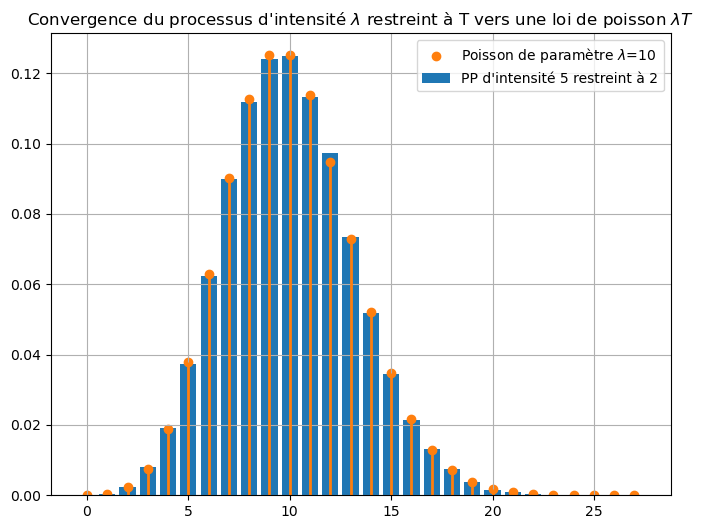

In [7]:
size = 100000
T = 2
lambd=5
poisson = stats.poisson(lambd*T)
sol  = [One_Poisson_Homogene_Inverse(lambd,T)[1:-1].size for _ in range(size)]
#Il faut exclure le premier et dernier point du calcul de taille, car le processus ne commence 
#véritablement qu'après avoir tiré une loi exponentielle inverse une fois, et la dernière
#valeur de sol est supérieur à T (on l'a transformé en T pour rendre le graphique plus beau,
#donc elle ne fait pas partie du processus. 


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité {lambd} restreint à {T}")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={lambd*T}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.set_title("Convergence du processus d'intensité $\lambda$ restreint à T vers une loi de poisson $\lambda T$")
ax.grid()
ax.legend()
plt.show()

### Processus de poisson non homogène


On considère un processus de Poisson de paramètre (ou l'intensité) $\lambda(t)$ est une fonction de R+ vers R+ intégrable.
Le processus de comptage {$N_t,t ∈ {\rm I\!R+}$} est appelé un processus de poisson non homogène d'intensité $\lambda(t)$ si $N_t$ satisfait : 
- Les incréments de $N_t$ sont indépendants entre eux
- $N_0=0$
- pour tout $t ∈ {\rm I\!R+}$, on a : $\mathbf{P}(N_{t+h}-N_t = 1) = \lambda(t)h + o(h)$  et  $\mathbf{P}(N_{t+h}-N_t > 2) = o(h)$ 



In [8]:
#Quelques fonctions que nous utiliserons comme paramètre des processus non homogènes et une redéfinition de l'intégrale pour 
#simplifier la lecture

def integrale(f,a,b):
    return quad(f,a,b)[0]


def f1(x):
    return x**2
def f2(x):
    return 1 + np.sin(x)
def f3(x):
    return 10*stats.norm(loc=2,scale=1).pdf(x)
def f4(x):
    return (5+np.exp(-x))/(2+np.sin(x))

nom_fonction = ["$f_{1}(x)=x^{2}$", "$f_{2}(x)=1+sin(x)$", "$f_{3}$ ~ $10*\mathcal{N}(2, 1)$",'$f_{4}=\\frac{5+e^{-x}}{2+sin(x)}$']

#### Simulation d'un processus non homogène par la méthode de la fonction inverse

Soit $N_t$ un processus de Poisson non homogène de fonction d’intensité $\lambda$ et de fonction moyenne Λ tel que Λ(𝑡) =$\int_0^t \lambda(a)\,da$, alors $N_t$ suit une loi de Poisson de paramètre Λ(t). 

Pour simuler ce processus de poisson, il suffit donc de simuler un processsus de poisson homogène d'intensité 1, puis d'appliquer la transformation $T_k = Λ^{-1}(t_k)$ avec $t_k$ les temps d'arrivées du processus homogène. (Méthode Cinlar)

Cette méthode est couteuse, et il existe un autre algorithme fonctionnant sur le même procédé que j'ai utilisé ici :
Cette méthode utilise la distribution conditionnelle inter-élément.

On considére les $X_i = T_{i+1}-T_i$ conditionné par les évènements $T_1=t_1,T_2=t_2...T_i=t_i$, Alors on a : 

$F_{t_i}(x) = \mathbf{P}(X_i<x | T_1=t_1,T_2=t_2...T_i=t_i) $<br>$= \mathbf{P}(N_{t_i+x}-N_{t_i} \geq 1 | T_1=t_1,T_2=t_2...T_i=t_i)
$<br>$= \mathbf{P}(N_{t_i+x}-N_{t_i} \geq 1)$<br>$ = 1 - \mathbf{P}(N_{t_i+x}-N_{t_i} = 0) $<br>$= 1 - exp(-Λ(t_i+x) + Λ(t_i))$

Pour trouver le temps $T_k$, il suffit donc de générer U uniforme et de résoudre $x = inf(x : F_t(x)\geq u)$, ici j'utilise une simple méthode de dichotomie.

In [9]:
#Calcul de x = inf(x : Ft(x) >= u)
def dichotomie(f,t,u,T, n=20):
    
    def Ft(x):
        return 1 - np.exp(-integrale(f,t,t+x))    
    
    a = 0
    b = T   
    for j in range(n):
        if Ft((a+b)/2)<u:
            a = (a+b)/2
        else : 
            b = (a+b)/2
    return (a+b)/2
    
def one_Poisson_nonHomogène_inversion(f,T):
       
    sol = [0]  
    while sol[-1]<T:        
        u = rng.uniform()
        t = dichotomie(f,sol[-1],u,T)
        sol.append(sol[-1]+t)
              
    sol[-1]=T
    return np.array(sol)

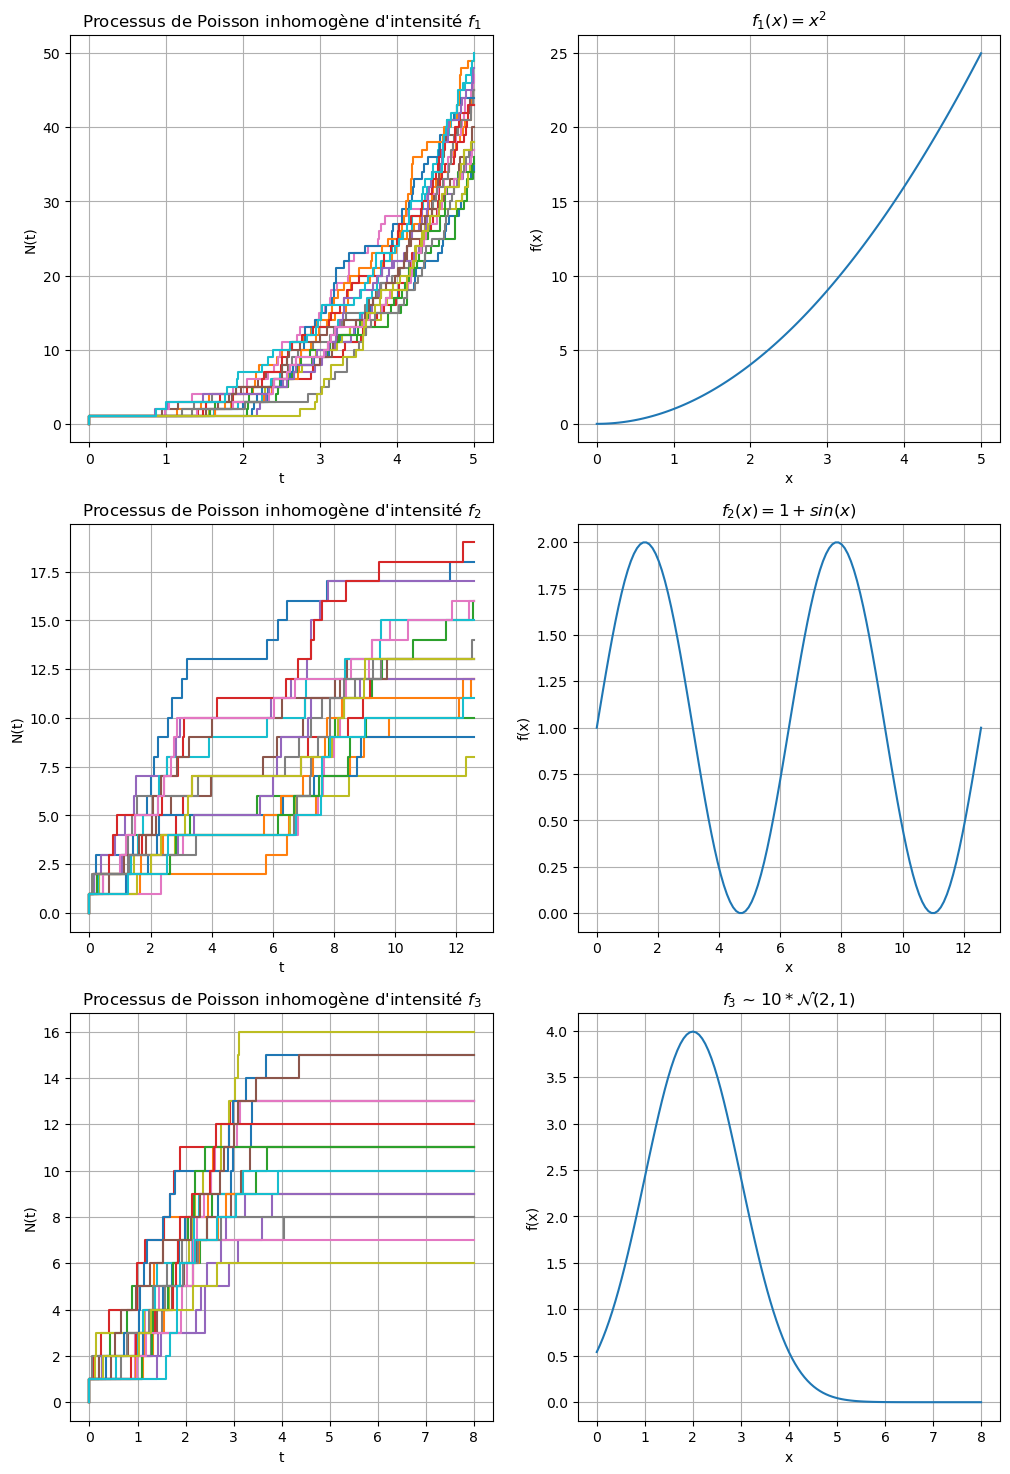

In [10]:
Ts = [5,4*np.pi,8]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol = [one_Poisson_nonHomogène_inversion(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(f"Processus de Poisson inhomogène d'intensité $f_{i+1}$")
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(nom_fonction[i])
plt.show()

On remarque que le temps d'exécution est relativement long, mais on y reviendra plus tard. 

#### Convergence du processsus homogène d'intensité $\lambda(t)$ restreint à T vers la loi de poisson d'intensité integrale $\int_0^T \lambda(a)\,da$
Le nombre d'arrivées dans n'importe quel interval d'un processus de poisson d'intensité $\lambda(t)$ suit une loi de Poisson.
Plus précisément, 
$$\normalsize  N_{t+s}-N_t \thicksim Poisson(\int_t^{t+s} \lambda(a)\,da)$$

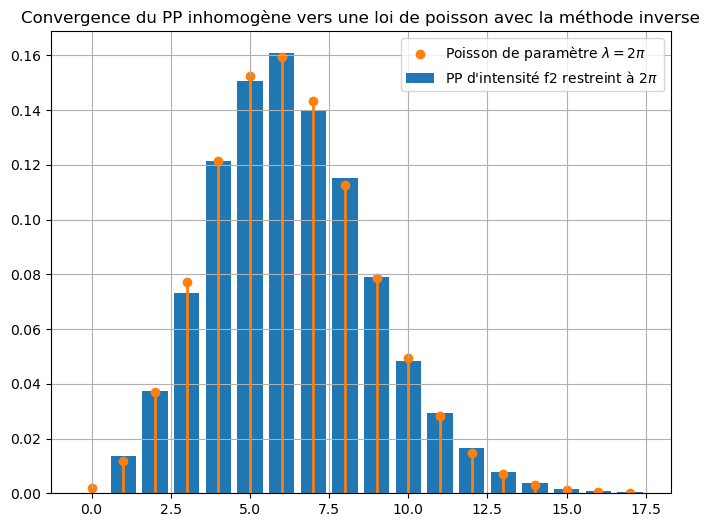

In [11]:
size = 10000
T = 2*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [one_Poisson_nonHomogène_inversion(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité f2 restreint à 2$\pi$")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda=2\pi$')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.grid()
ax.legend()
ax.set_title('Convergence du PP inhomogène vers une loi de poisson avec la méthode inverse')
plt.show()

## Partie 2 : Thinning algorithm



### Splitting d'un processus de poisson homogène par une loi de bernouilli 

On commence par une version basique mais très proche de la méthode de thinning, qui consiste simplement à un diviser processus de poisson selon une loi de bernouilli.

Soit $N_t$ un processus de poisson d'intensité $\lambda$. Si, pour chaque arrivée, on tire une variable de bernouilli B
de paramètre p, tel que si B=1 l'arrivée est envoyé vers le processus $N^{(1)}_t$ et sinon vers $N^{(2)}_t$, alors :

 -$N^{(1)}_t$ est un processus de poisson homogène d'intensité $\lambda p$ <br>
 -$N^{(2)}_t$ est un processus de poisson homogène d'intensité $(1-\lambda) p$

In [12]:
def One_Poisson_Splitting(lambd, T, p):
      
    process = One_Poisson_Homogene_Inverse(lambd, T)

    accep = [0]
    rejet = [0]
    U = rng.uniform(size=process.size)
    
    for i in range(process.size) :
       
        if U[i]<=p:
            accep.append(process[i])
        else : 
            rejet.append(process[i])
    return np.array(accep), np.array(rejet)
            
def Poisson_Splitting(lambd, T, p, sample_size):
    sol1 = []
    sol2 = []
    for j in range(sample_size):
        temp1,temp2 = One_Poisson_Splitting(lambd, T, p)
        sol1.append(temp1[1:-1].size)
        sol2.append(temp2[1:-1].size)
    return np.array(sol1), np.array(sol2)
        

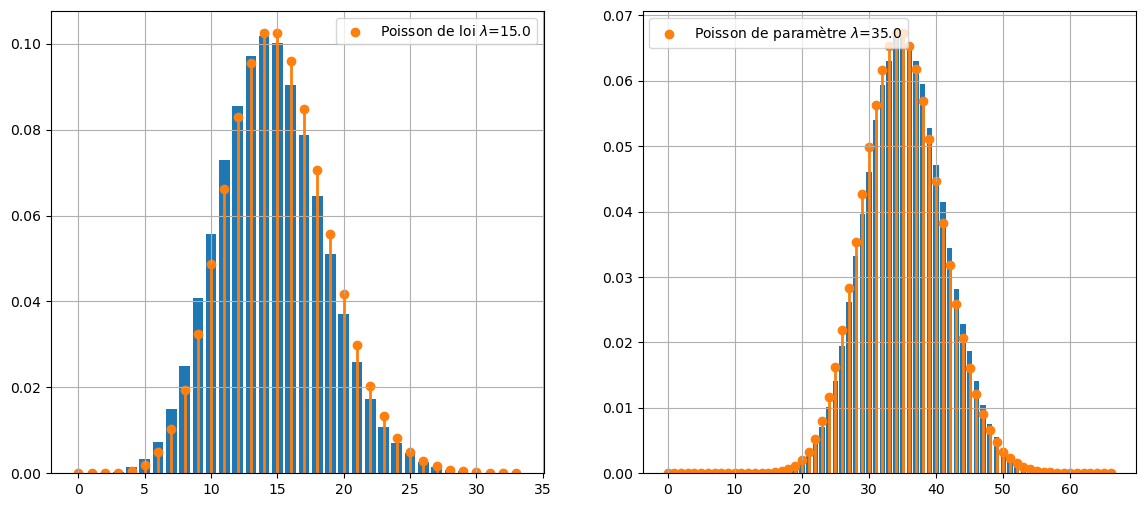

In [13]:
size = 100000
T = 10
lambd=5
p=0.3
poisson1 = stats.poisson(T*lambd*p)
poisson2 = stats.poisson(T*lambd*(1-p))
sol1,sol2  = Poisson_Splitting(lambd, T, p, size)


fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
support = np.arange(np.max(sol1)+1)
empirical_pro = np.bincount(sol1,minlength=np.max(sol1))/sol1.size
ax1.bar(support,empirical_pro)
ax1.scatter(support, poisson1.pmf(support), label=f'Poisson de loi $\lambda$={round(T*p*lambd,2)}')
ax1.vlines(support, 0, poisson1.pmf(support), color='C1', lw=2, alpha=1)
ax1.grid()
ax1.legend()


ax2 = fig.add_subplot(1,2,2)
support = np.arange(np.max(sol2)+1)
empirical_pro = np.bincount(sol2,minlength=np.max(sol2))/sol2.size
ax2.bar(support,empirical_pro)
ax2.scatter(support, poisson2.pmf(support), label=f'Poisson de paramètre $\lambda$={round((1-p)*lambd*T,2)}')
ax2.vlines(support, 0, poisson2.pmf(support), color='C1', lw=2, alpha=1)
ax2.grid()
ax2.legend()
plt.show()


### Simulation d'un processus non homogène par la méthode de thinning
Théorème de Lewis et Shedler : Soit un processus de Poisson d'intensité $\lambda_u(t), t\geq 0$. Supposons que
les $T_{1}^{*},T_{1}^{*},....,T_{n}^{*}$ sont des variables aléatoires représentant les temps d'arrivées pour ce processus de poisson, se situant entre 0 et T. Sois $\lambda(t)$ une fonction d'intensité telle que $0\leq \lambda(t) \leq \lambda_u(t)$
pour $t ∈ [0,T]$. Si le i-ème temps d'arrivée $T_{i}^{*}$ est rejeté avec probabilité $1-\large\frac{\lambda(t)}{\lambda_u(t)}$ pour $i=1,2...n$, alors les points restant forment un processus de Poisson non homogène d'intensité $\lambda(t)$ restreint à $T$.

Pour la première implémentation, j'utilise $\lambda_u(t)=sup_t \lambda(t)$.

In [14]:
#Recherche du sup de f sur l'intervalle [0,T]

def sup(f,t1,t2):
    intervalle = np.linspace(t1,t2,5)
    x0 = t1
    for x in intervalle:
        if(f(x)>f(x0)):
            x0 = x
    xmax = optimize.minimize(lambda x: -f(x), x0, bounds=[(t1,t2)]).x[0]
    return f(xmax)

J'utilise la fonction optimize.minimize de Scipy. Cependant, cette fonction ne renvoit pas toujours un maximum global
et se retrouve souvent bloqué dans un maximum local ( minimum normalement, mais j'optimise -f donc c'est bien un maximum de f ). Pour contrer cela, j'essaie, de manière très rudimentaire, de chercher un point x0 optimale en évaluent la fonction sur 5 points et d'initaliser optimize.minimize avec le point qui maximize f.

In [15]:
def Poisson_nonHomogène_thinning(f,T):
    
    
    lambd = sup(f,0,T)
        
    #Generation d'un processus de poisson d'intensité lambd (le max de f sur l'intervalle [0,T])
    
    process = One_Poisson_Homogene_Sort(lambd,T)

   
    sol = [0]

    for p in process :
        
        #Seul les points validant le critère sont gardés
        d = rng.uniform()
        if d<=f(p)/lambd:
            sol.append(p)

    sol[-1]=T
    return np.array(sol)


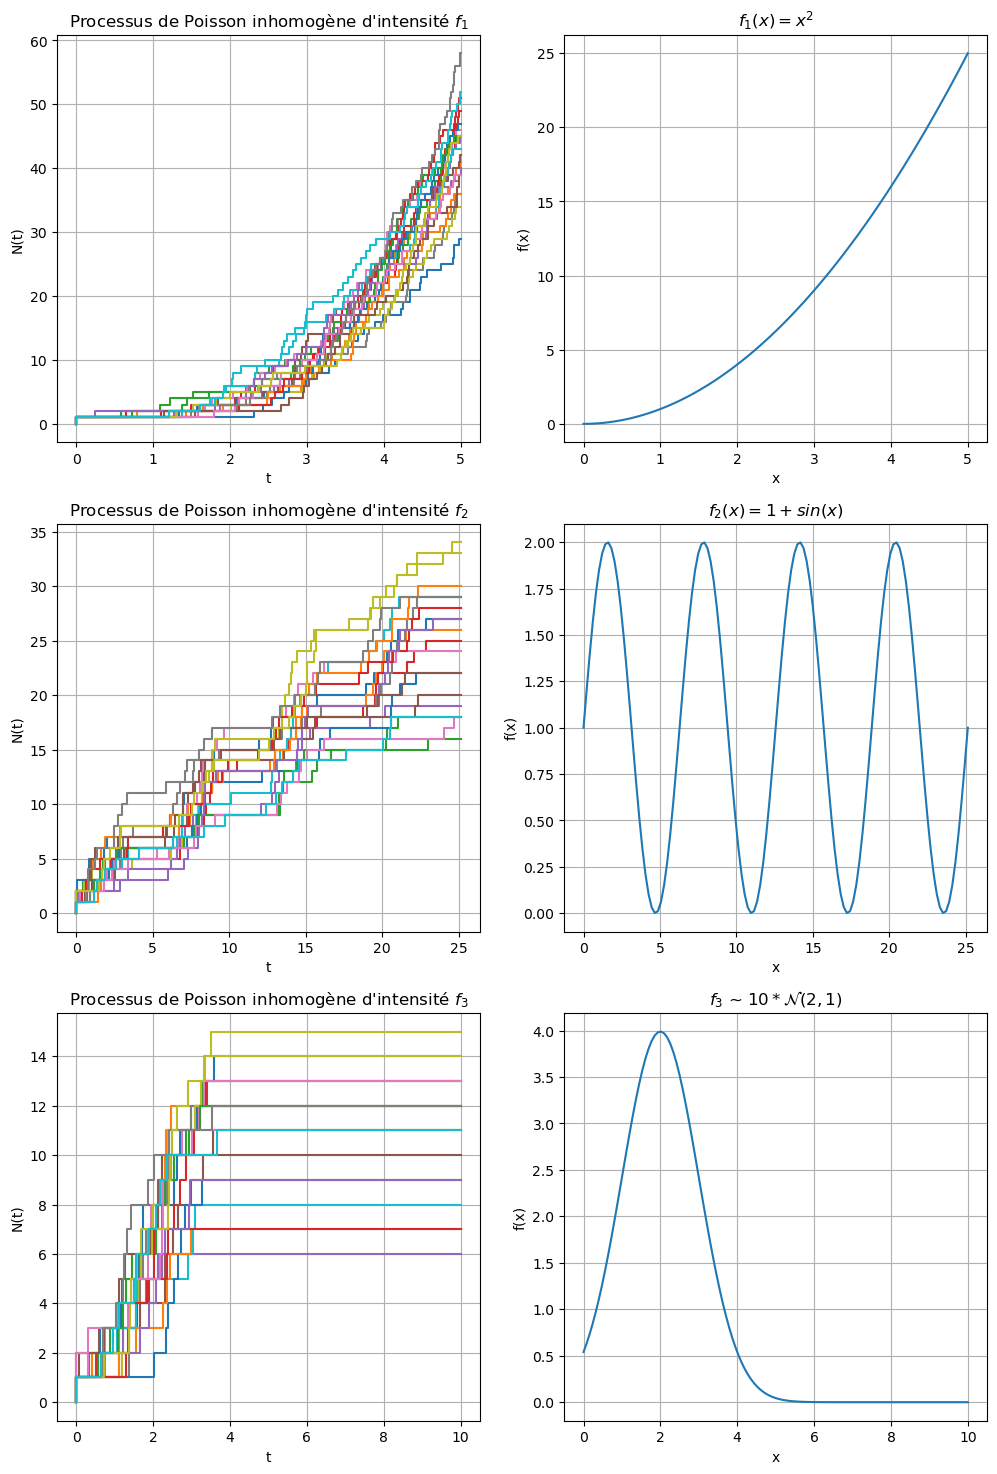

In [16]:
Ts = [5,8*np.pi,10]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol  = [Poisson_nonHomogène_thinning(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(f"Processus de Poisson inhomogène d'intensité $f_{i+1}$")
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(nom_fonction[i])

plt.show()

        

On remarque immédiatement que cette méthode est beaucoup plus rapide ! 

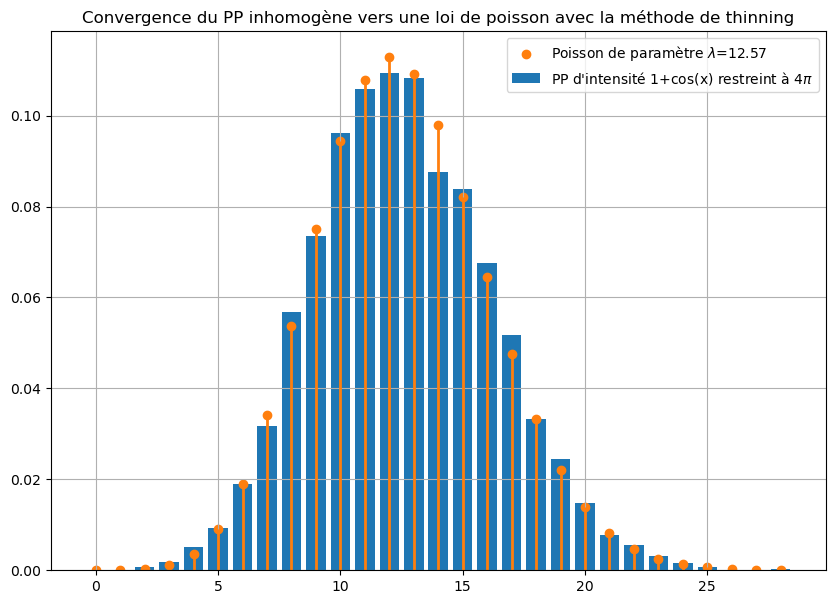

In [17]:
size = 10000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [Poisson_nonHomogène_thinning(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité 1+cos(x) restreint à 4$\pi$")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.set_title('Convergence du PP inhomogène vers une loi de poisson avec la méthode de thinning')
ax.grid()
ax.legend()
plt.show()

#### Illustration de la méthode de thinning

In [18]:
#Je réécris la méthode pour l'illustration plus bas

def Poisson_nonHomogène_thinning_illustration(f,T):
    
    #Recherche du sup de f sur l'intervalle [0,T]
    
    lambd = sup(f,0,T)
    
    #Generation d'un processus de poisson d'intensité lambd 
    
    process = One_Poisson_Homogene_Inverse(lambd,T)
 
    accep = []
    rejet = []
    accepd = []
    rejetd = []
    for p in process :
       
        d = rng.uniform()
        if d<=f(p)/lambd:
            accep.append(p)
            accepd.append(d*lambd)
        else : 
            rejet.append(p)
            rejetd.append(d*lambd)
    sol[-1]=T
    return np.array(accep),np.array(rejet),np.array(accepd),np.array(rejetd)

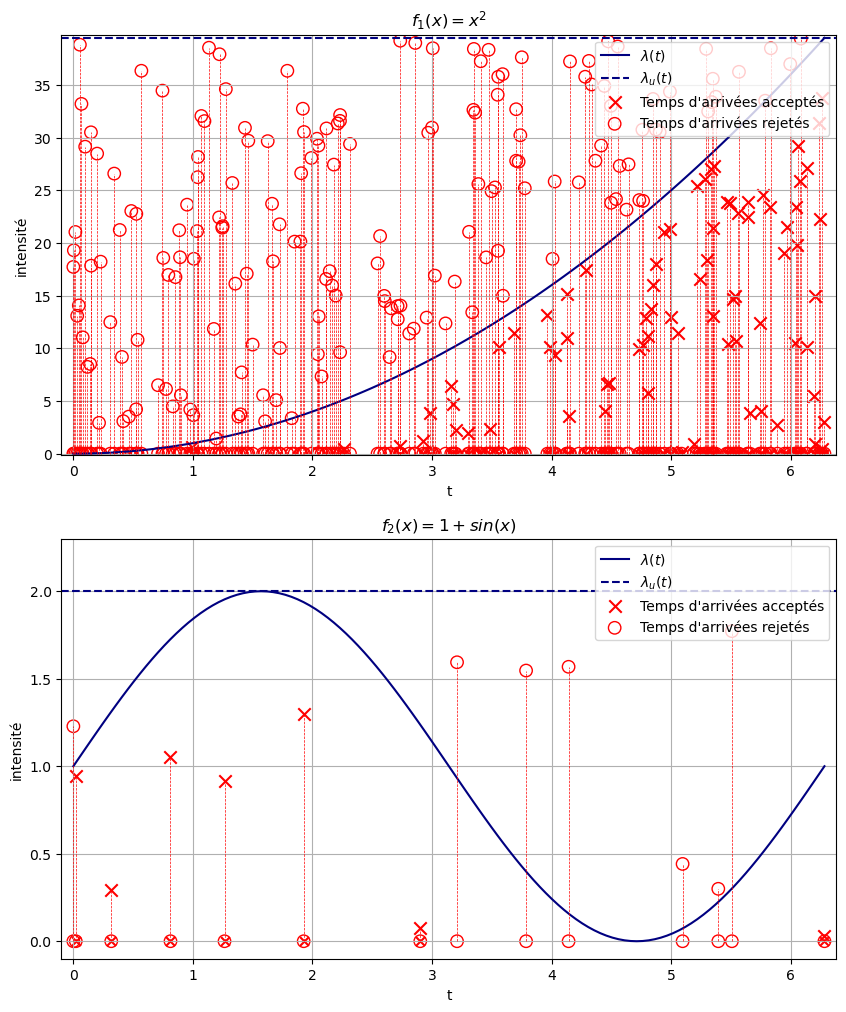

In [19]:
T = 2*np.pi
fs = [f1,f2]
fig = plt.figure(figsize=(10,6*len(fs)))


for i,f in enumerate(fs):
    lambd = sup(f,0,T)
    accep, rejet, accepd, rejetd = Poisson_nonHomogène_thinning_illustration(f,T)

    ax = fig.add_subplot(len(fs),1,i+1)

    xx = np.linspace(0,T,125)
    ax.plot(xx,f(xx),label="$\lambda(t)$",color='navy')
    ax.axhline(y=lambd,linestyle='--',label="$\lambda_u(t)$",color='navy')

    ax.scatter(accep,np.zeros(accep.size), s=80, facecolors='none', edgecolors='r')
    ax.scatter(accep,accepd, marker='x', s=80,color='r',label="Temps d'arrivées acceptés")
    ax.scatter(accep,np.zeros(accep.size), marker='x', s=40,color='r')

    ax.scatter(rejet,np.zeros(rejet.size), s=80, facecolors='none', edgecolors='r',label="Temps d'arrivées rejetés")
    ax.scatter(rejet,rejetd, s=80, facecolors='none', edgecolors='r')

    for j in range(accep.size):
        ax.plot(np.array([accep[j],accep[j]]),np.array([0,accepd[j]]),linestyle='--',color='r',linewidth=0.5)
    for j in range(rejet.size):
        ax.plot(np.array([rejet[j],rejet[j]]),np.array([0,rejetd[j]]),linestyle='--',color='r',linewidth=0.5)

    ax.set_xlim(-0.1,T+0.1)
    ax.set_ylim(-0.1,lambd+0.3)
    ax.grid()
    ax.set_xlabel('t')
    ax.set_ylabel('intensité')
    ax.set_title(f"{nom_fonction[i]}")
    ax.legend(loc="upper right")
plt.show()

#Regardez plutôt le deuxième graphique en premier, qui est beaucoup plus clair !

Un problème évident est mis en avant par ces illustrations, le nombre de points rejetés. <br>
En particulier, si la fonction d'intensité $\lambda(t)$ possède un maximum sur [0,T] qui est très important 
comparé à sa valeur moyenne, il faudra simuler un processus d'intensité très forte $\lambda_{u}(t)$, qui conduira
à une quantité très importante de points rejetés.

### Simulation d'un processus non homogène par une méthode de thinning subdivisée

Pour optimiser l'algorithme, on va chercher à réduire au maximul le nombre de points rejetés. Au lieu d'utiliser 
$\lambda_u(t)=sup_t \lambda(t)$, on divise la fonction en plusieurs morceaux et on calcule $\lambda_u(t)$ pour chaque morceau.
Ensuite, il suffit de générer un processus homogène d'intensité $\lambda_u(t)$ pour chaque morceau et de procéder comme la méthode de thinning.


In [20]:
def Poisson_nonHomogène_subdivision(f,T,nb_intervalles = 2):
          
    sol = [0]
    intervalles = np.linspace(0,T,nb_intervalles+1)
    for T_temp,T_temp_avant in zip(intervalles[1:],intervalles[:-1]):
           
        lambd_u = sup(f,T_temp_avant,T_temp)    
        process = One_Poisson_Homogene_Sort(lambd_u,T_temp)[1:-1] + sol[-1]
        
        i = 0 
        while sol[-1]<T_temp and i<process.size:
            d = rng.uniform()
            if d<=f(process[i])/lambd_u:
                sol.append(process[i])

            i+=1          
            
    sol[-1]=T

    return np.array(sol)



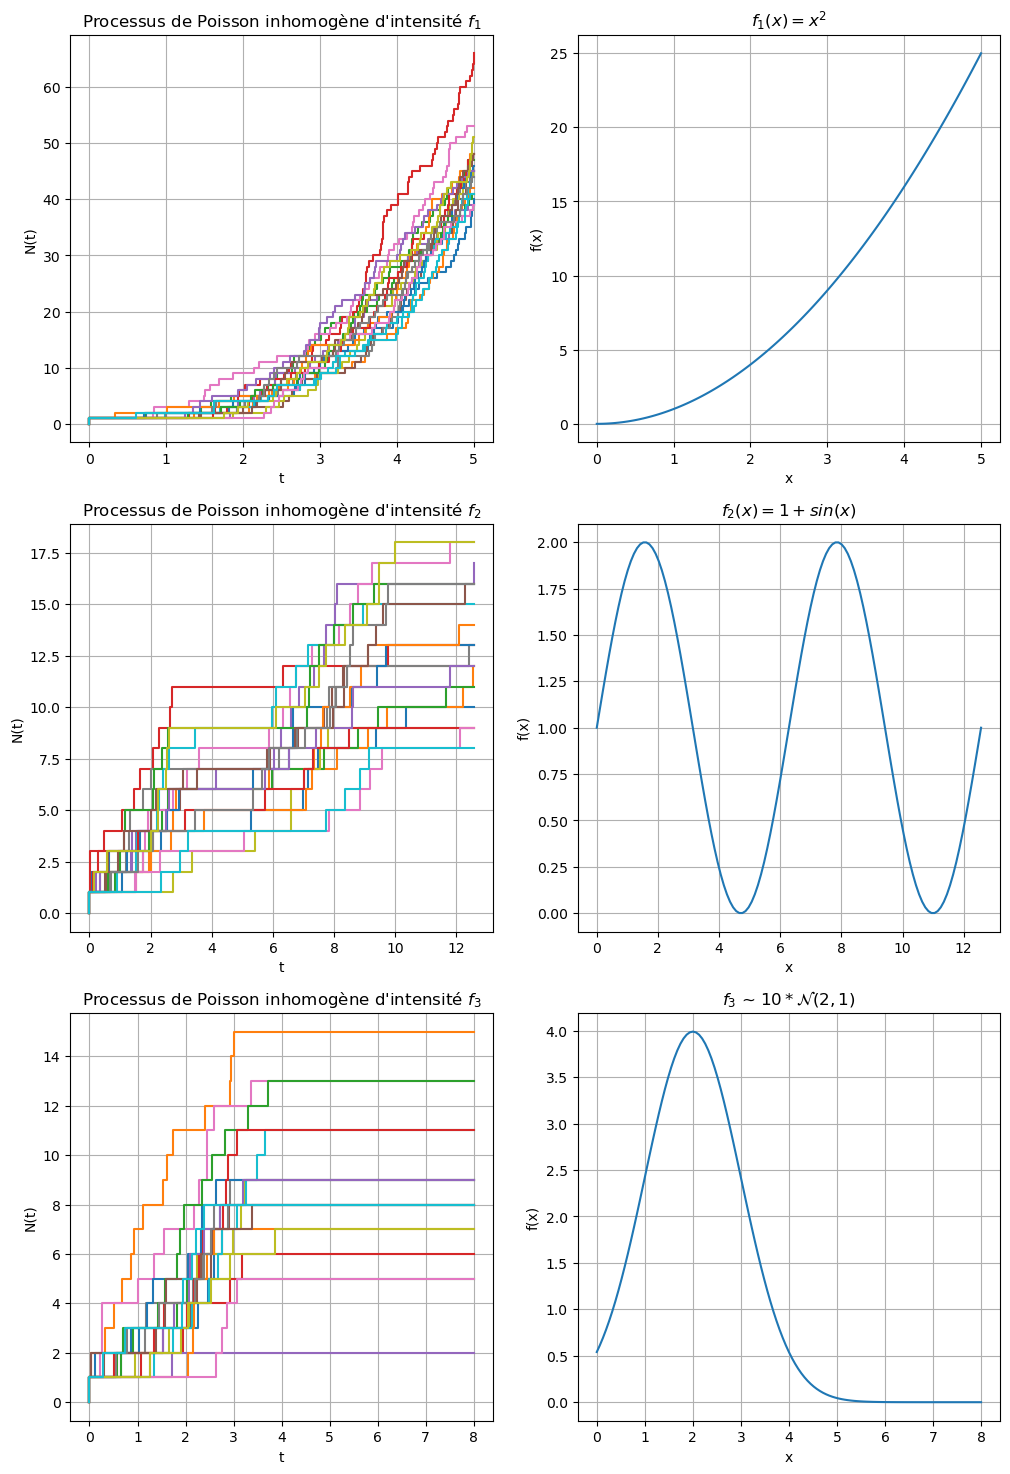

In [21]:
Ts = [5,4*np.pi,8]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol  = [Poisson_nonHomogène_subdivision(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(f"Processus de Poisson inhomogène d'intensité $f_{i+1}$")
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(nom_fonction[i])

plt.show()



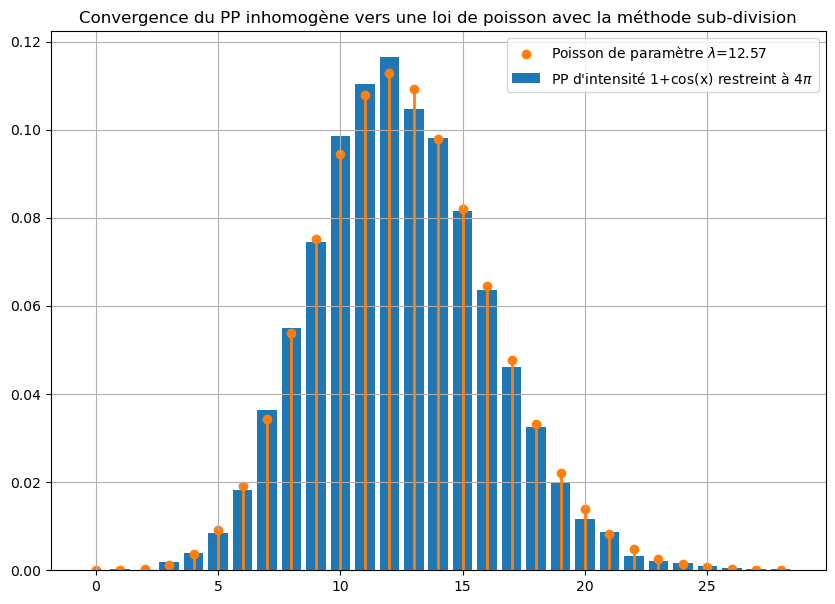

In [22]:
size = 10000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [Poisson_nonHomogène_subdivision(f,T)[2:-1].size for _ in range(size)]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité 1+cos(x) restreint à 4$\pi$")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.set_title('Convergence du PP inhomogène vers une loi de poisson avec la méthode sub-division')
ax.grid()
ax.legend()
plt.show()

## Partie 3 : Comparaison des performances

Nous avons donc écrit 3 algorithmes pour simuler un processus de poisson non homogène. Il faut maintenant comparer leurs performances en utilisant divers fonctions.

ATTENTION : La 1ère et 3ème cellules sont longues à exécuter selon la puissance de votre ordinateur 

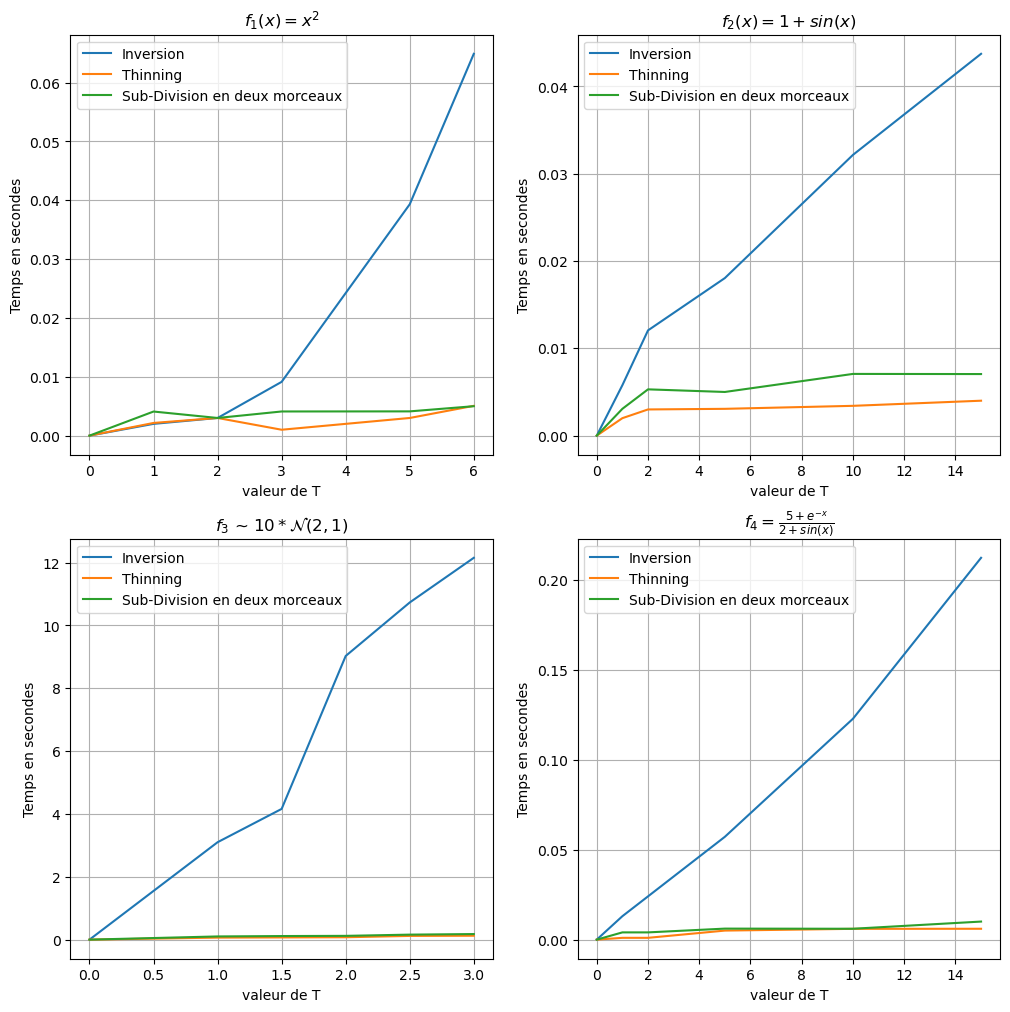

In [23]:
Ts = np.array([[0,1,2,3,5,6],[0,1,2,5,10,15],[0,1,1.5,2,2.5,3],[0,1,2,5,10,15]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(12,12))

methodes = [one_Poisson_nonHomogène_inversion, 
           Poisson_nonHomogène_thinning,
           Poisson_nonHomogène_subdivision]

nom = ['Inversion','Thinning','Sub-Division en deux morceaux']
titre = ['$f(x)=x^{2}$','$f(x)=1+sin(x)$','f3','f4']
for i,f in enumerate(fs) : 
    temps = [[0],[0],[0]]

    for T in Ts[i,1:]:
        for t,m in zip(temps,methodes):
            start = time.time()
            sol = [m(f,T) for _ in range(10)]
            end = time.time()
            t.append(end-start)
        
    ax = fig.add_subplot(2,2,i+1)
    for j,t in enumerate(temps):
        ax.plot(Ts[i],t,label=nom[j])
    ax.legend()
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()
    

Clairement, la méthode de thinning et sa variante sont bien plus rapide que la méthode d'inversion.
On va comparer plus en détail ces deux dernières méthodes : 

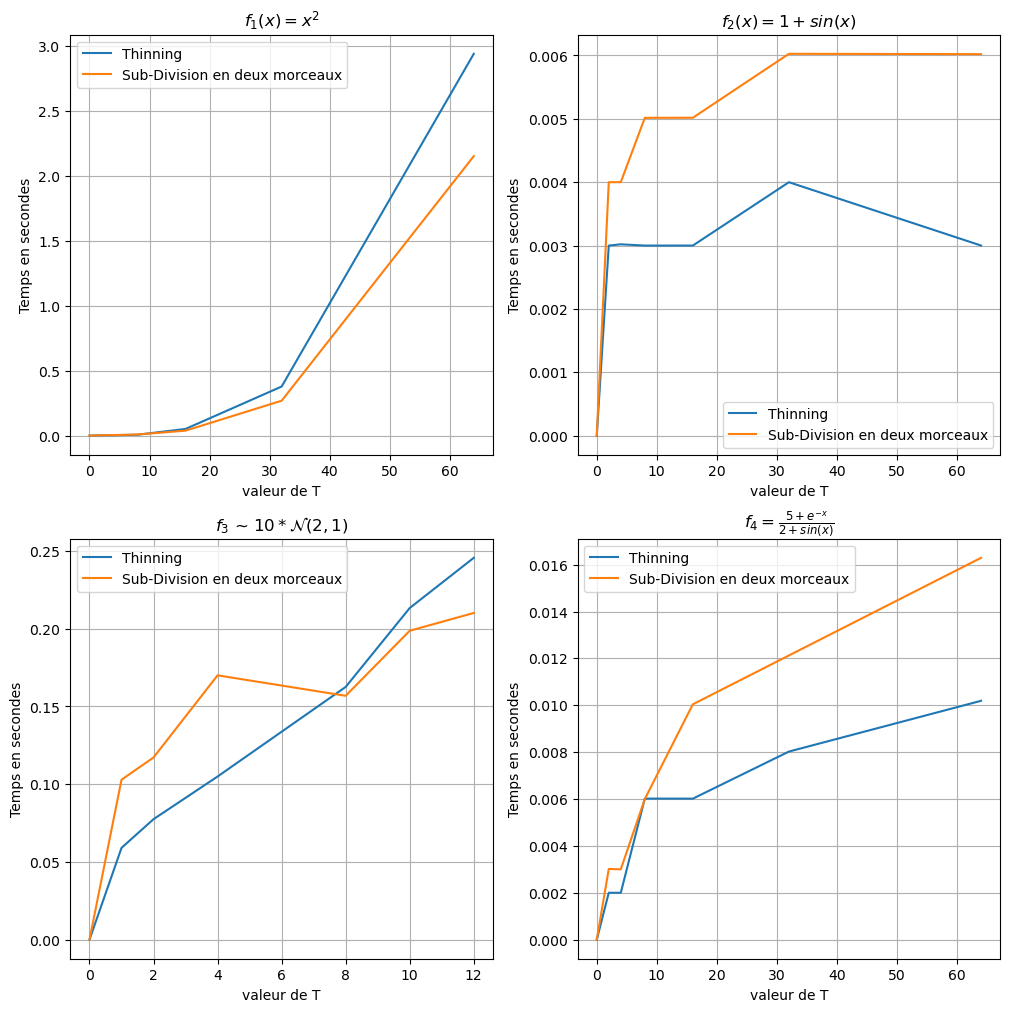

In [24]:
Ts = np.array([[0,2,4,8,16,32,64],[0,2,4,8,16,32,64],[0,1,2,4,8,10,12],[0,2,4,8,16,32,64]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(12,12))

methodes = [Poisson_nonHomogène_thinning, Poisson_nonHomogène_subdivision]

nom = ['Thinning','Sub-Division en deux morceaux']
for i,f in enumerate(fs) : 
    temps = [[0],[0]]

    for T in Ts[i,1:]:
        for t,m in zip(temps,methodes):
            start = time.time()
            sol = [m(f,T) for _ in range(10)]
            end = time.time()
            t.append(end-start)
        
    ax = fig.add_subplot(2,2,i+1)
    for j,t in enumerate(temps):
        ax.plot(Ts[i],t,label=nom[j])
    ax.legend()
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()

On remarque que les performances de ces deux algorithmes dépend de $\lambda(t)=f(t)$. L'explication est intuitivement claire : Plus la fonction présente des écarts important entre son maximum et sa valeur moyenne, plus l'algorithme de sub-division prend de l'interêt. En effet, dans ce cas là, ne calculer que une seule fois le maximum de f entraine un nombre important de 
rejets. 

Théroriquement, la méthode de sub-division devrait être meilleur ou égale à la méthode de thinning, selon la valeur de $\lambda_{u}$ comparé à la moyenne de $\lambda(t)$. En pratique, la mauvaise optimisation de la recherche du sup $\lambda_u$ ralentit la fonction sub-division si couper la fonction en deux ou plus est inutile.

Cependant, il existe probablement une valeur optimale du nombre de subdivision, ce que l'on va vérifier dans ce dernier graphique : 

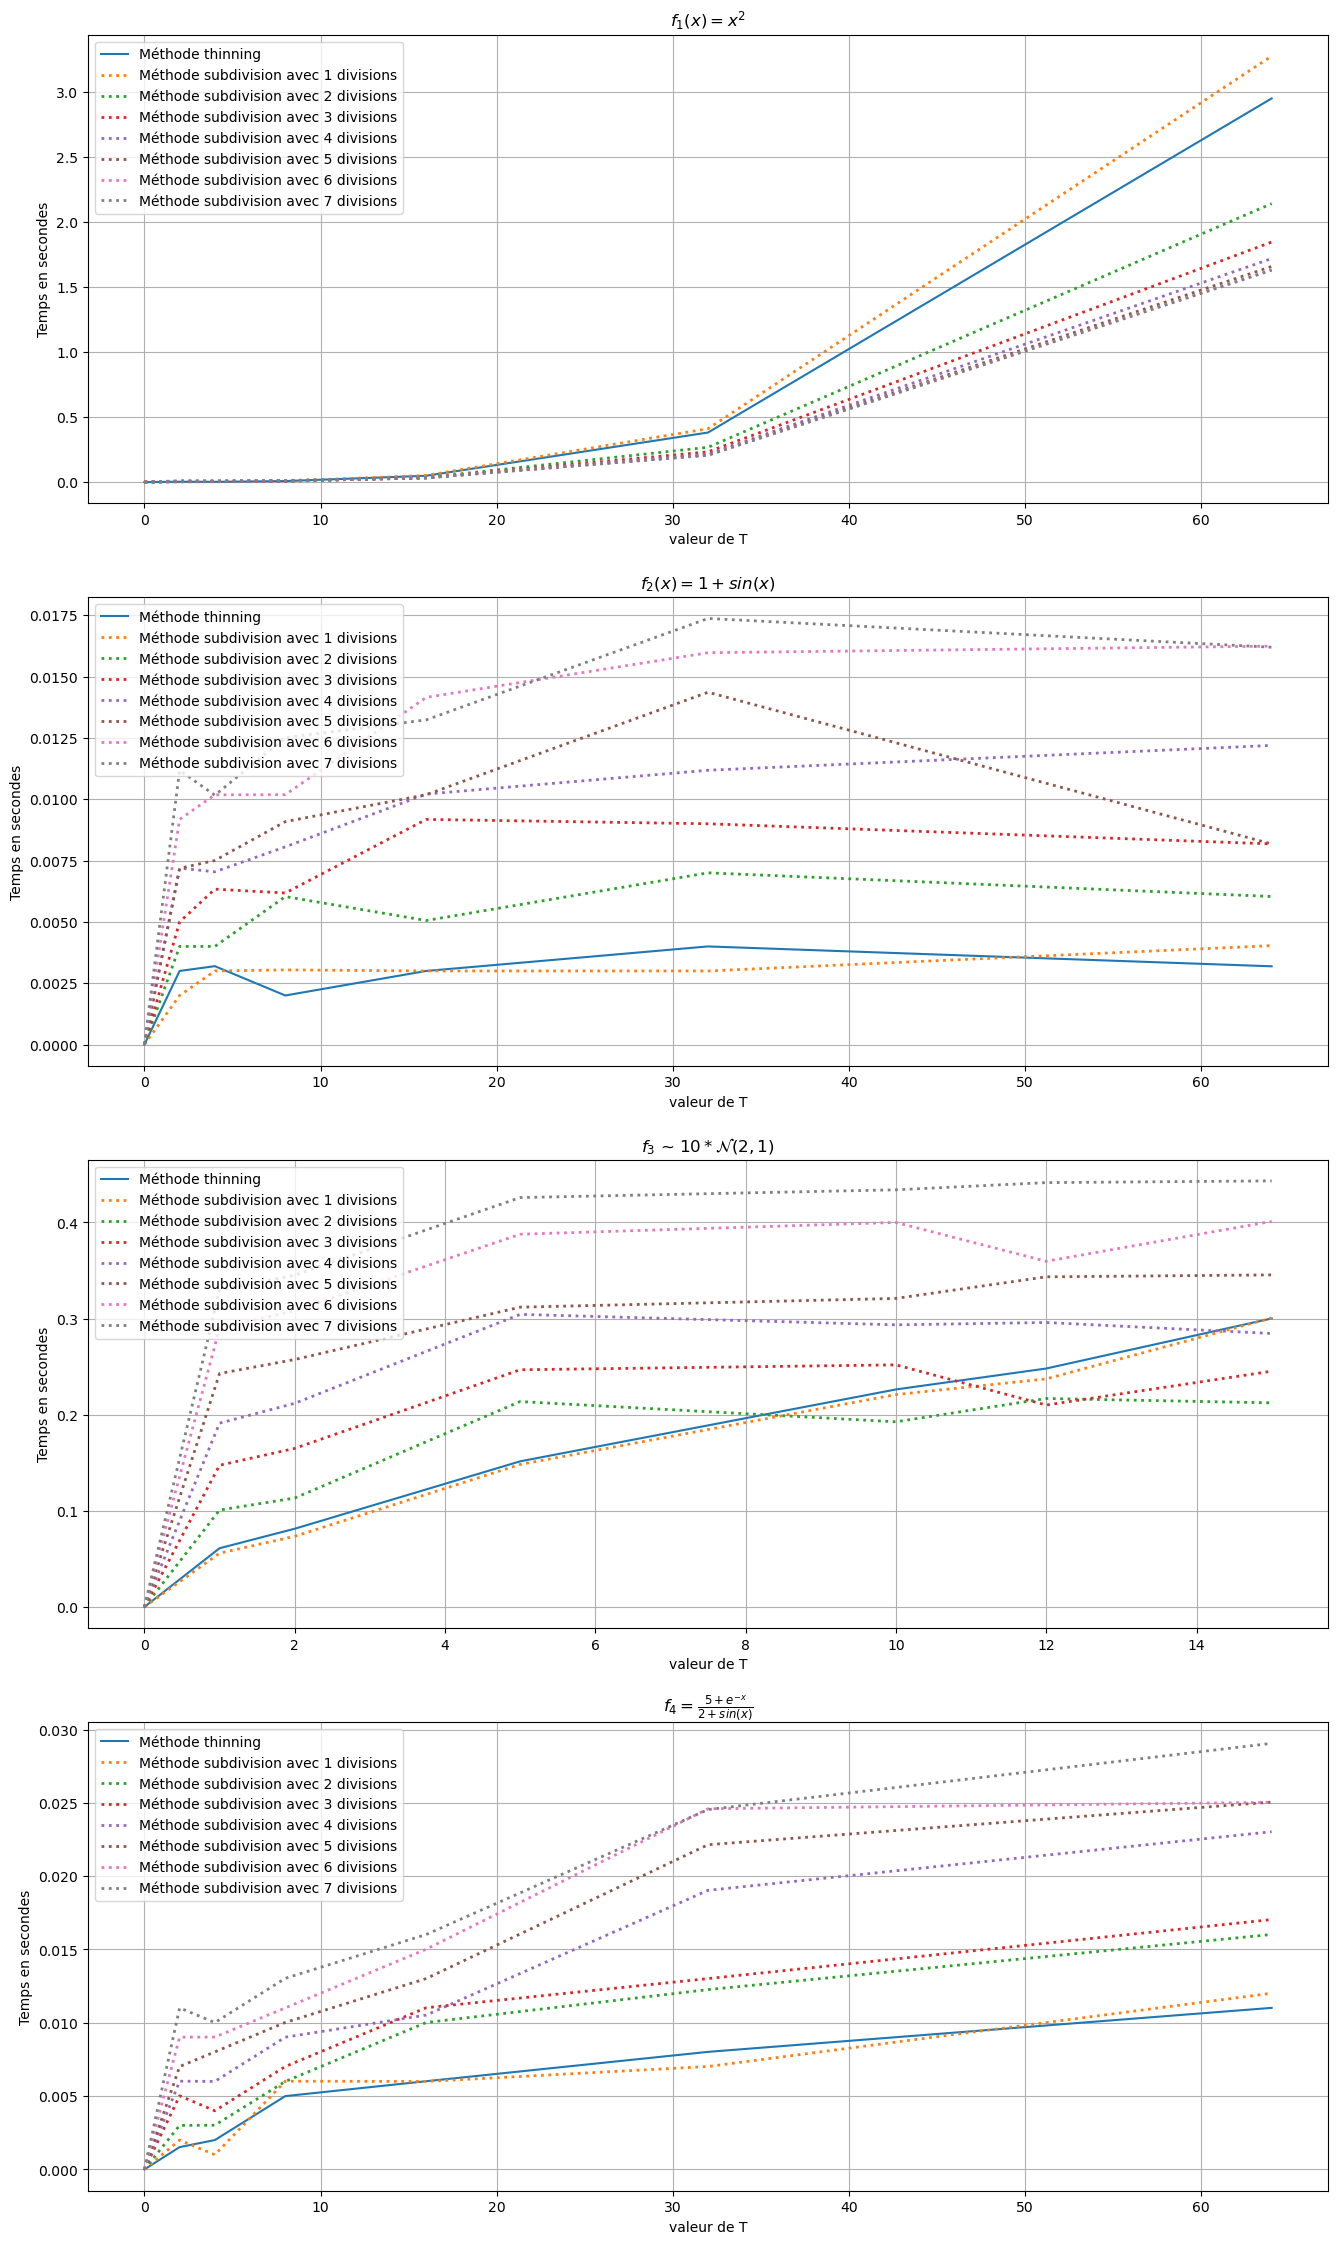

In [25]:
Ts = np.array([[0,2,4,8,16,32,64],[0,2,4,8,16,32,64],[0,1,2,5,10,12,15],[0,2,4,8,16,32,64]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(16,28))

methodes = [Poisson_nonHomogène_thinning, Poisson_nonHomogène_subdivision]

nom = ['Thinning','Sub-Division']
for i,f in enumerate(fs) : 
    ax = fig.add_subplot(4,1,i+1)
    temp = [0]
    for T in Ts[i,1:]:
        start = time.time()
        sol = [Poisson_nonHomogène_thinning(f,T) for _ in range(10)]
        end = time.time()
        temp.append(end-start)
    ax.plot(Ts[i],temp,label='Méthode thinning')
    
    for j in range(1,8):
        temp = [0]
        for T in Ts[i,1:]:
            start = time.time()
            sol = [Poisson_nonHomogène_subdivision(f,T,j) for _ in range(10)]
            end = time.time()
            temp.append(end-start)
        ax.plot(Ts[i],temp,label=f'Méthode subdivision avec {j} divisions',linestyle='dotted',linewidth=2)
    
    
    ax.legend(loc="upper left")
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()

Comme prévu, augmenter le nombre de sub-divisions n'entraine pas une hausse des performances, mais plutôt le contraire à cause du temps de calcul de recherche du sup. 

Dans le cas de $f_1=x^{2}$, on remarque cependant une augmentation des performances corrélé au nombre de sub-divisions. De même pour $f_{3}$ ~ $\mathcal{N}(2, 1)$, plus on s'éloigne de la moyenne en t=2, plus les performances de l'algorithme de sub-division rattrapent la performance de la méthode de thinning.  Cette méthode semble donc pertinente dans certains cas limite.

On pourrait donc réécrire la méthode de subdivision, en incluant une nouvelle partie qui calculerait automatiquement les intervalles de divisions optimaux (le cas nb_intervalles = 1 correspond à la méthode de thinning simple). Reste à trouver mathématiquement cette valeur..
<br> <br>

Il existe bien sûr des algorithmes plus puissants pour simuler des processsus de poisson non homogènes, comme celui présenté dans cet article de recherche:

https://yunanliu.wordpress.ncsu.edu/files/2019/11/CIATApublished.pdf